# Running Dask on AzureML

You may need torun source activate azureml_py36 && pip install dask distributed...

![Describe gif](media/describe-video.gif)

Let's import some stuff

In [1]:
import os, time, socket
from azureml.core import Workspace, Experiment
from azureml.widgets import RunDetails
from azureml.core.runconfig import RunConfiguration, MpiConfiguration
from azureml.train.estimator import Estimator
from azureml.core.compute import ComputeTarget, AmlCompute

## Get the workspace

In [3]:
ws = Workspace.from_config()
ws

Workspace.create(name='ncus-azureml', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')

## Create an Azure ML cluster

In [4]:
if 'ds13-cluster' not in ws.compute_targets:
    # create config for Azure ML cluster
    # change properties as needed
    config = AmlCompute.provisioning_configuration(
             vm_size                 = 'STANDARD_DS13_V2',
             max_nodes               = 100,
             vnet_resourcegroup_name = ws.resource_group,
             vnet_name               = 'dask-vnet',
             subnet_name             = 'default'
    )
    
    ct = ComputeTarget.create(ws, 'dask-cluster', config)
    ct.wait_for_completion(show_output=True)    
else:
    ct = ws.compute_targets['ds13-cluster']
    
ct

AmlCompute(workspace=Workspace.create(name='ncus-azureml', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg'), name=ds13-cluster, id=/subscriptions/6560575d-fa06-4e7d-95fb-f962e74efd7a/resourceGroups/copetersrg/providers/Microsoft.MachineLearningServices/workspaces/ncus-azureml/computes/ds13-cluster, type=AmlCompute, provisioning_state=Succeeded, location=northcentralus, tags=None)

## Create a Dataset

In [5]:
if 'weather-files' not in ws.datasets:
    ds = Dataset.File.from_files('https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/*/*/*.parquet', validate=False)
    ds = ds.register(ws, 'weather-files')
else:
    ds = ws.datasets['weather-files']
    
ds

{
  "source": [
    "https://azureopendatastorage.blob.core.windows.net/isdweatherdatacontainer/ISDWeather/*/*/*.parquet"
  ],
  "definition": [
    "GetFiles"
  ],
  "registration": {
    "id": "c0fe2407-f46d-4462-b993-f23ed423bd15",
    "name": "weather-files",
    "version": 1,
    "workspace": "Workspace.create(name='ncus-azureml', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copetersrg')"
  }
}

## Start the run

The below 2 cells submit the run to the Azure ML cluster and monitor its status. Depending on your compute target and `environment.yaml` the setup time may vary. The second cell launches a widget to monitor the run. Soon after the run's status is 'Running' the setup for using the cluster in a Dask Client is performed with necessary information logged to the run. This will show up in the widget and run details page in the studio.

The widget gets stuck a lot, refresh it if the duration is not increasing.

![Run widget](media/run-widget.png)

In [7]:
script_params = {
    '--datastore': ws.get_default_datastore(),
    #'--script'   : 'run.py' # run code in run.py on cluster and teardown 
}

In [64]:
est = Estimator('dask', 
                compute_target          = ct, 
                entry_script            = 'startDask.py', 
                conda_dependencies_file = 'environment.yml', 
                script_params           = script_params,
                inputs                  = [ds.as_named_input('weather').as_download('/tmp/noaa')],
                node_count              = 40,
                distributed_training    = MpiConfiguration()
               )

#run = next(ws.experiments['dask'].get_runs()) # uncomment to get existing run (if kernel restarted, etc)
run = Experiment(ws, 'dask-batch').submit(est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask-batch,dask-batch_1577068351_5dba039f,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [65]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET',…

## Wait for cluster to setup

Wait for the cluster to spin up, the run to start, and the `startDask.py` process complete. At this point, information needed for connecting the cluster will be logged back to the run.

The below cell waits for that information to be logged to the run, sets up port forwarding for the Dask dashboard, and prints the url. Make sure to check out the dashboard as you run through the rest of the notebook! 

In [72]:
# port to forward the dask dashboard to on the compute instance (ci)
# we do not use 8787 because it is already in use on the ci  
ci_port = 9797

print("waiting for scheduler node's ip")
while run.get_status() != 'Canceled' and 'scheduler' not in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

if run.get_status() == 'Canceled':
    print('Run was canceled')
else:
    dashboard_url = f'https://{socket.gethostname()}-{ci_port}.{ws.get_details()["location"]}.instances.azureml.net/status'

    cmd = f'setsid socat tcp-listen:{ci_port},reuseaddr,fork tcp:{run.get_metrics()["dashboard"]} &'
    print(f'\nSetting up port forwarding for dashboard with command: {cmd}')
    os.system(cmd)
    print(f'Cluster is ready to use and dashboard can be viewed at {dashboard_url}.')

waiting for scheduler node's ip

Setting up port forwarding for dashboard with command: setsid socat tcp-listen:9797,reuseaddr,fork tcp:10.1.0.7:8787 &
Cluster is ready to use and dashboard can be viewed at https://instance-9797.northcentralus.instances.azureml.net/status.


## Dask dashboard

Copy and paste the url into your browser to view the dask dashboard. 



In [71]:
print(dashboard_url)

https://instance-9798.northcentralus.instances.azureml.net/status


## Connect to cluster through Dask Client

In [73]:
import dask
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client

c = Client(f'tcp://{run.get_metrics()["scheduler"]}')
c.restart()
c

Client Scheduler: tcp://10.1.0.7:8786 Dashboard: http://10.1.0.7:8787/status,Cluster Workers: 40 Cores: 320 Memory: 2.36 TB


## Have fun

Go try out any of the [dask examples](https://github.com/dask/dask-examples). You'll need to connect to the client from any other notebook you run. Or continue below running what I have so far for using the dataset. 

In [74]:
import glob

files = dask.delayed(glob.glob)('/tmp/noaa/**/*.parquet', recursive=True).compute()
#files

Build the dask array from many Pandas dataframes

In [75]:
df = dd.from_delayed([dask.delayed(pd.read_parquet)(file) for file in files])

In [76]:
df.npartitions

144

Optionally, you could repartition the data like this. See the dask best practices for recommendations around partitioning. 

In [77]:
#df = df.repartition(npartitions=10*df.npartitions)
#df.npartitions

On a distributed cluster, you can perisist a data in the distributed RAM. Again, see the dask best pratices for recommendations around persisting data

In [78]:
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,480010,99999,2008-05-01 03:00:00,27.333,97.417,409.0,230.0,0.5,22.0,1008.0,...,5.0,NaN,NaN,NaN,PUTAO,BM,480010-99999,2008,1,1.0
1,480010,99999,2008-05-01 06:00:00,27.333,97.417,409.0,0.0,0.0,25.0,1005.8,...,NaN,NaN,NaN,NaN,PUTAO,BM,480010-99999,2008,1,1.0
2,480010,99999,2008-05-01 09:00:00,27.333,97.417,409.0,0.0,0.0,20.0,1009.4,...,5.0,NaN,NaN,NaN,PUTAO,BM,480010-99999,2008,1,1.0
3,480010,99999,2008-05-01 12:00:00,27.333,97.417,409.0,0.0,0.0,27.0,1001.8,...,2.0,NaN,NaN,NaN,PUTAO,BM,480010-99999,2008,1,1.0
4,480010,99999,2008-05-02 03:00:00,27.333,97.417,409.0,0.0,0.0,22.0,1005.4,...,5.0,NaN,NaN,NaN,PUTAO,BM,480010-99999,2008,2,1.0


Let's see how long it takes to find the length of the dataset. Without the data persisted, it will take a few tens of seconds

In [79]:
%time len(df)

CPU times: user 211 ms, sys: 2.17 ms, total: 213 ms
Wall time: 7.57 s


1396216646

## Setup and perisist data for quicker analysis 

Setup the index and persist the dataframe in distributed RAM for quicker processing. Fully expanded, this dataset is ~550 GB. Since we are sorting the data, this will take a long time. This cell can be skipped, but will affect the performance of the later cells. 

In [80]:
df.datetime = dd.to_datetime(df.datetime).dt.floor('d')
df = df.set_index(df.datetime, sorted=False).persist()

Note this will persist the data asynchronously. You can check the dashboard to see the status. The time to find the length of the dataframe will drop to under a second after the data is persisted. This may take a while, check out the graph:

![Index graph](media/index-graph.png)

In [83]:
%time len(df)

CPU times: user 27.9 ms, sys: 376 µs, total: 28.3 ms
Wall time: 220 ms


1396216646

## Check out the graph on this bad boy

Let's profile the dataset to find useful statistics.

In [84]:
df.describe().compute()

,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.396217e+09,1.396217e+09,1.396217e+09,1.121423e+09,1.164553e+09,1.370989e+09,4.935403e+08,1.262732e+08,5.196196e+07,2.935522e+08,2.935522e+08,7.996754e+06,1.396217e+09,1.396217e+09,1.396217e+09
mean,3.743921e+01,-3.926299e+01,3.969070e+02,1.651349e+02,3.437453e+00,1.202833e+01,1.014650e+03,2.964050e+01,4.272739e+00,9.340661e+00,1.059272e+03,1.823921e+01,2.013765e+03,1.568660e+01,1.000000e+00
std,2.156708e+01,7.856501e+01,6.091156e+02,1.145395e+02,2.863989e+00,1.247015e+01,9.356271e+00,2.925401e+01,2.998545e+00,2.016060e+01,3.062605e+03,3.396985e+01,3.406793e+00,8.809036e+00,0.000000e+00
min,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-9.130000e+01,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.008000e+03,1.000000e+00,1.000000e+00
25%,3.404700e+01,-9.114800e+01,4.600000e+01,8.000000e+01,2.000000e+00,8.300000e+00,1.011800e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.012000e+03,1.100000e+01,1.000000e+00
50%,4.163300e+01,-4.807100e+01,2.010000e+02,2.000000e+02,3.100000e+00,1.600000e+01,1.017100e+03,5.000000e+01,5.000000e+00,3.000000e+00,0.000000e+00,1.500000e+01,2.016000e+03,1.900000e+01,1.000000e+00
75%,4.918300e+01,2.102700e+01,5.500000e+02,2.800000e+02,5.700000e+00,2.770000e+01,1.027000e+03,7.100000e+01,8.000000e+00,1.800000e+01,9.999000e+03,6.200000e+01,2.019000e+03,2.700000e+01,1.000000e+00
max,8.733300e+01,9.999990e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.170000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,9.990000e+02,2.019000e+03,3.100000e+01,1.000000e+00


## View mean values over time

In [86]:
means = df.groupby(df.index).mean().compute()
means.head()

,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2008-01-01,37.851544,-41.404520,351.706004,176.364994,4.031225,0.791217,1021.312605,29.191647,4.171073,5.199203,47.503108,21.776100,2008.0,1.0,1.0
2008-01-02,37.774122,-40.943714,352.504602,180.436673,4.306232,-0.932920,1021.165374,32.632597,4.152460,5.355434,44.483105,22.627133,2008.0,2.0,1.0
2008-01-03,37.781321,-40.130623,352.634351,156.904648,4.358461,-0.866068,1020.247739,32.471547,4.119097,5.402424,47.639126,23.396628,2008.0,3.0,1.0
2008-01-04,37.879647,-40.516726,353.027684,149.716467,4.318913,1.212171,1017.653427,30.277898,3.897811,5.524803,39.277930,22.328746,2008.0,4.0,1.0
2008-01-05,37.956239,-41.565558,358.450412,161.096456,4.328847,3.918379,1013.838332,30.640481,4.154117,5.342658,39.990708,23.943632,2008.0,5.0,1.0


In [88]:
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline 

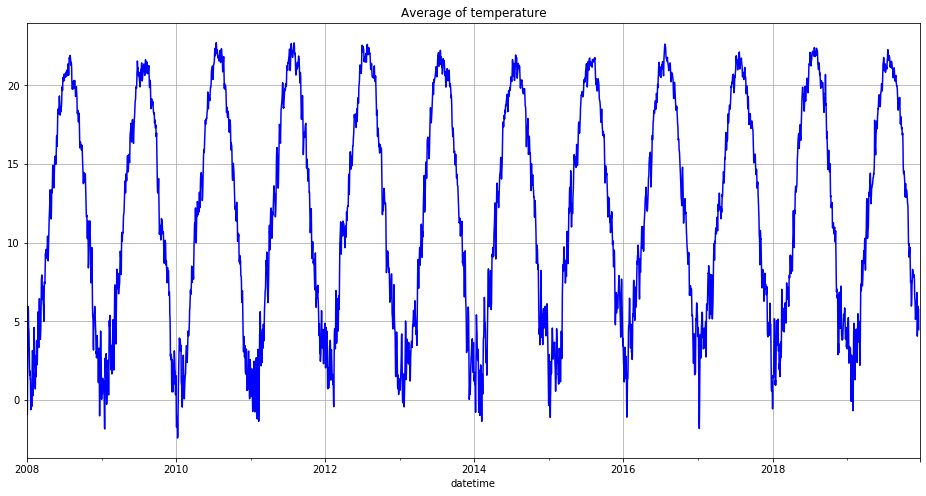

In [91]:
fig = plt.figure(figsize=(16, 8))
means['temperature'].plot(color='b')
plt.title('Average of temperature')
plt.xlim([datetime(2008, 1, 1), datetime.now()])
plt.grid()

In [93]:
# optionally, log the image to the run
run.log_image('avg_temperature', plot=plt)

<Figure size 432x288 with 0 Axes>

## Plot average of each feature

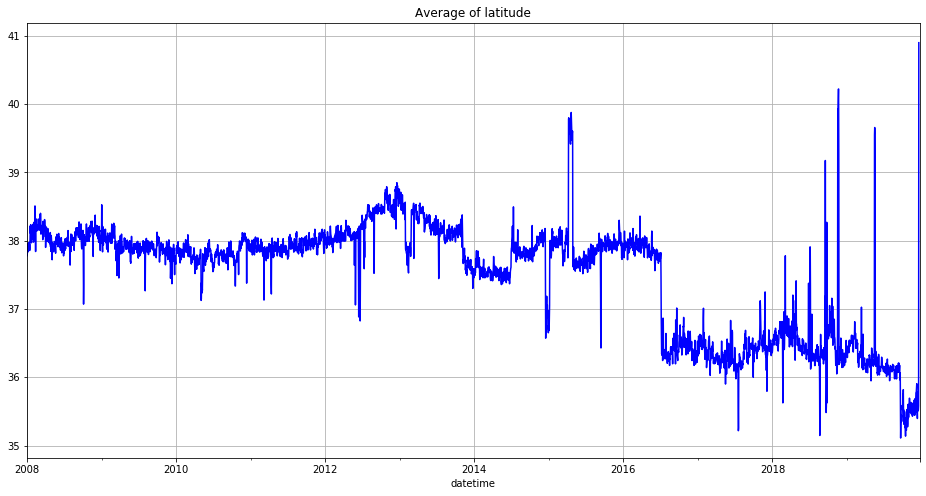

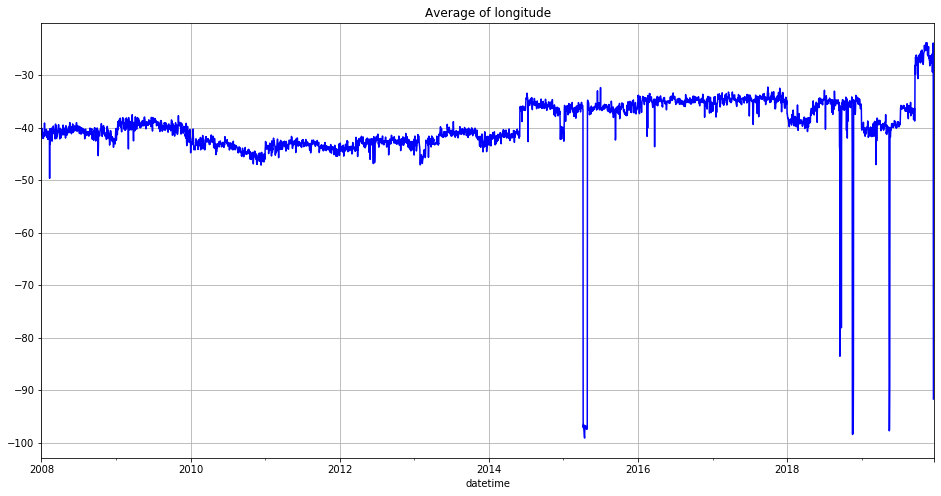

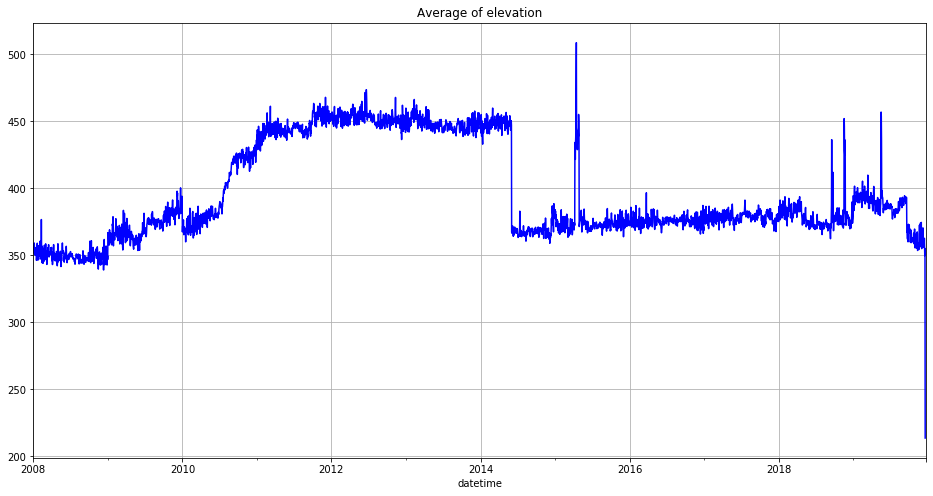

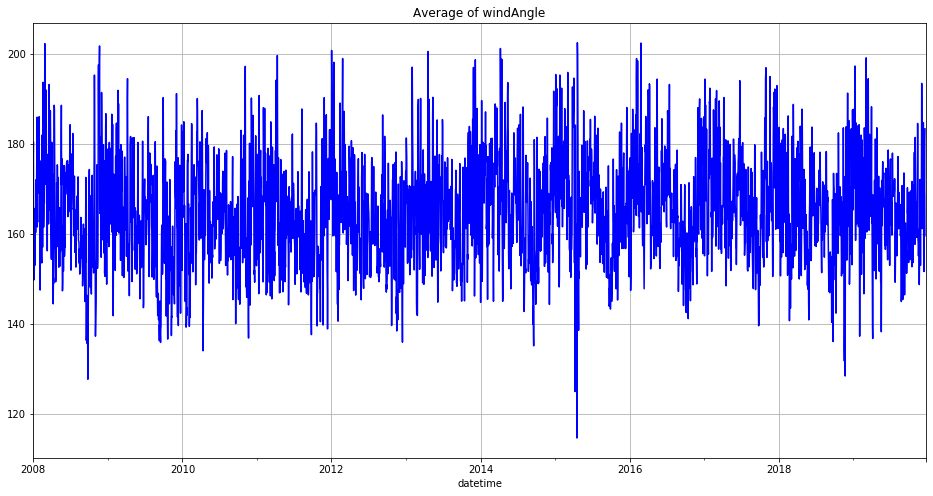

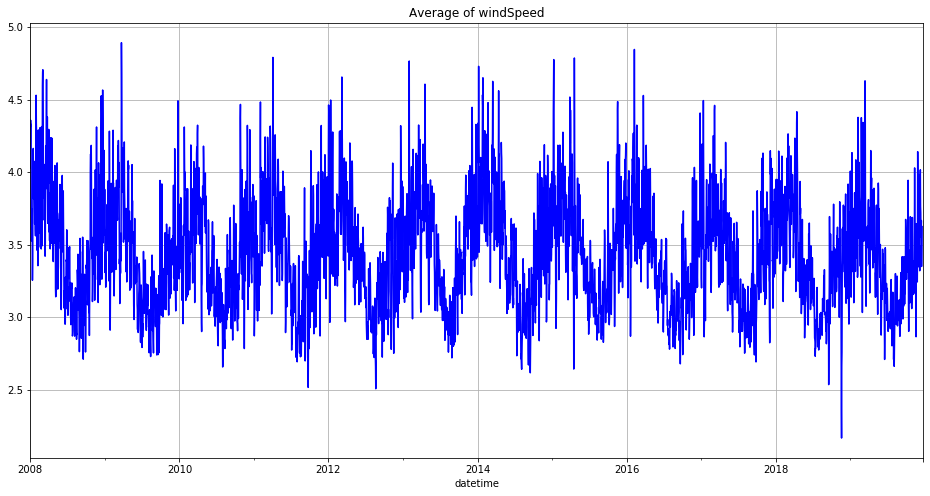

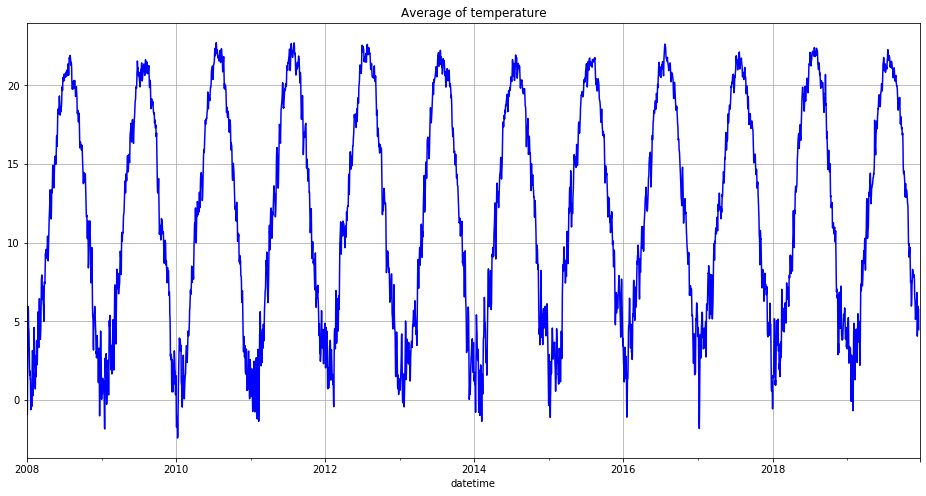

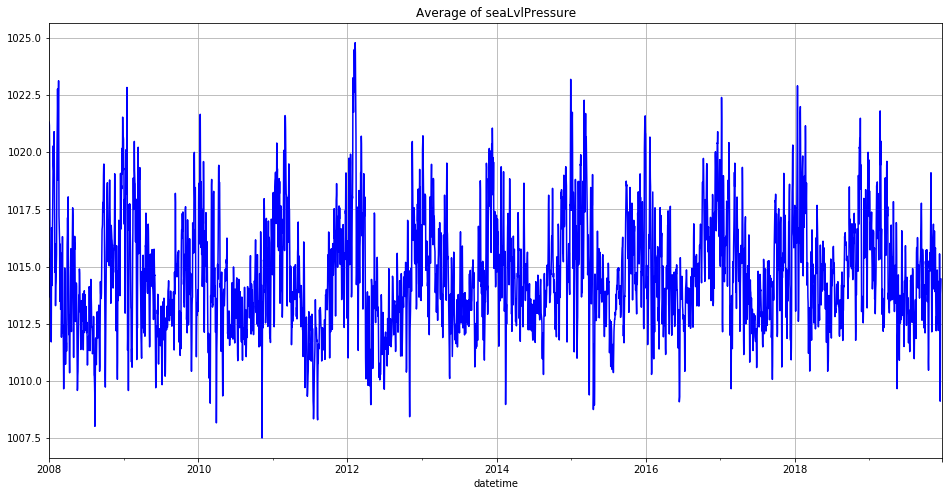

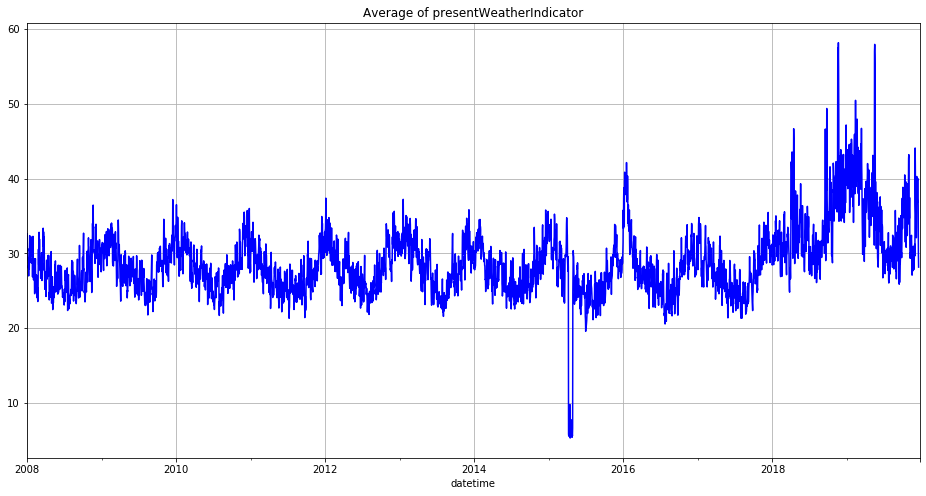

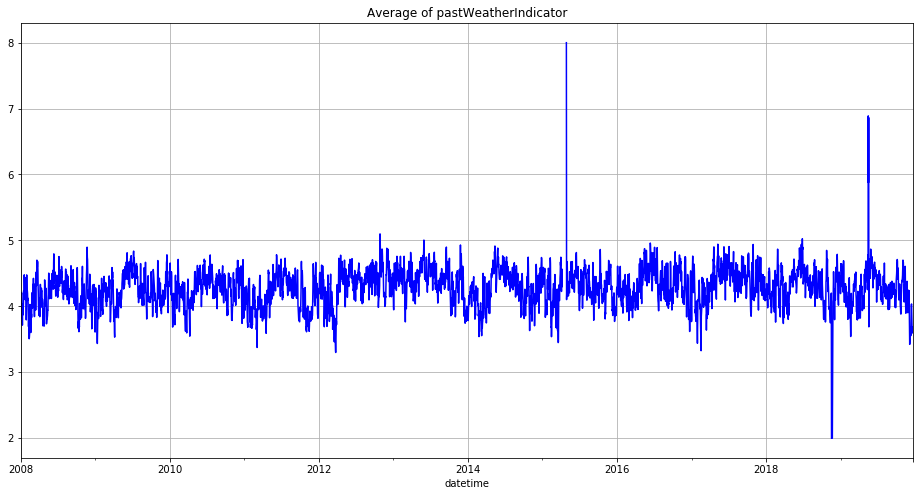

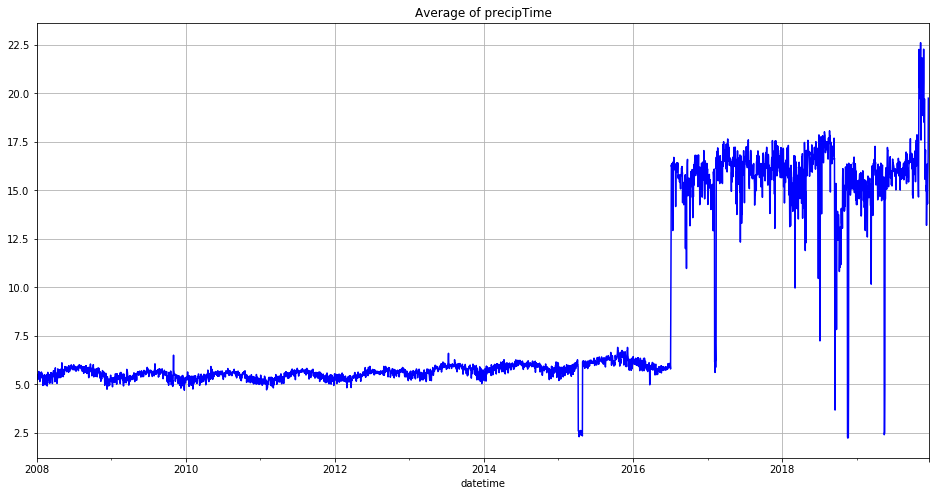

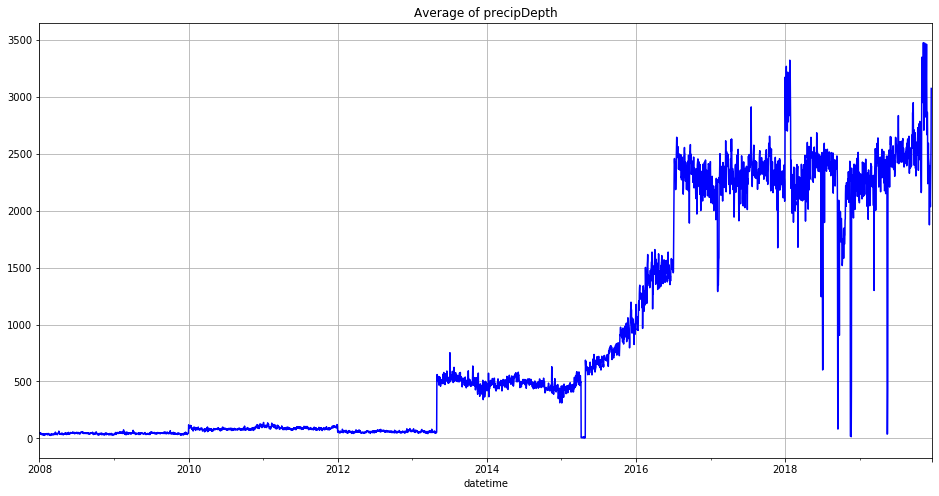

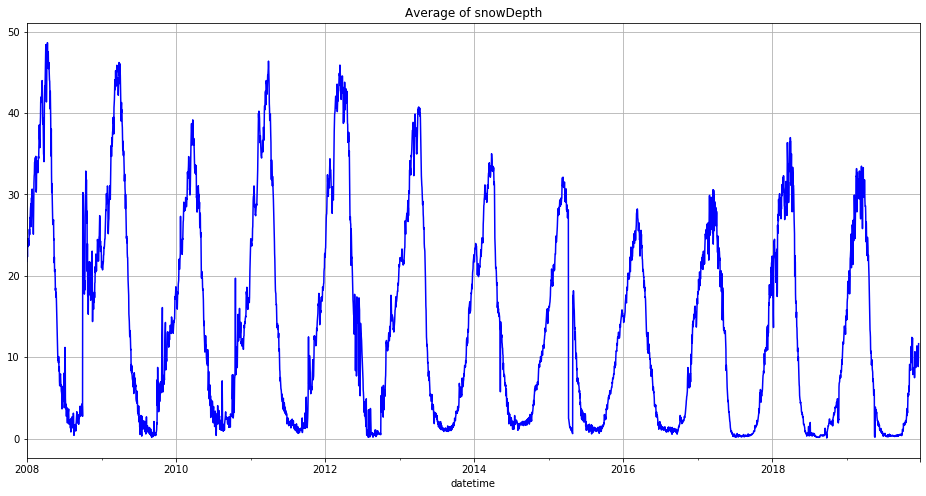

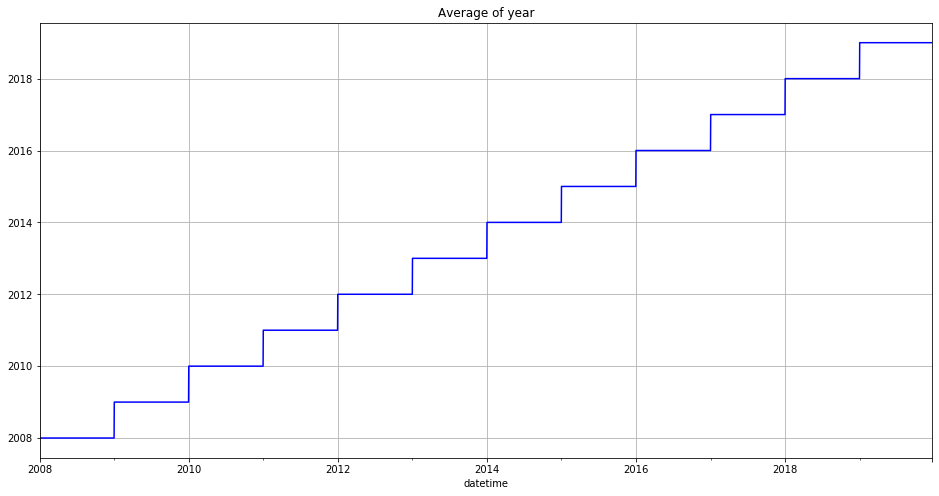

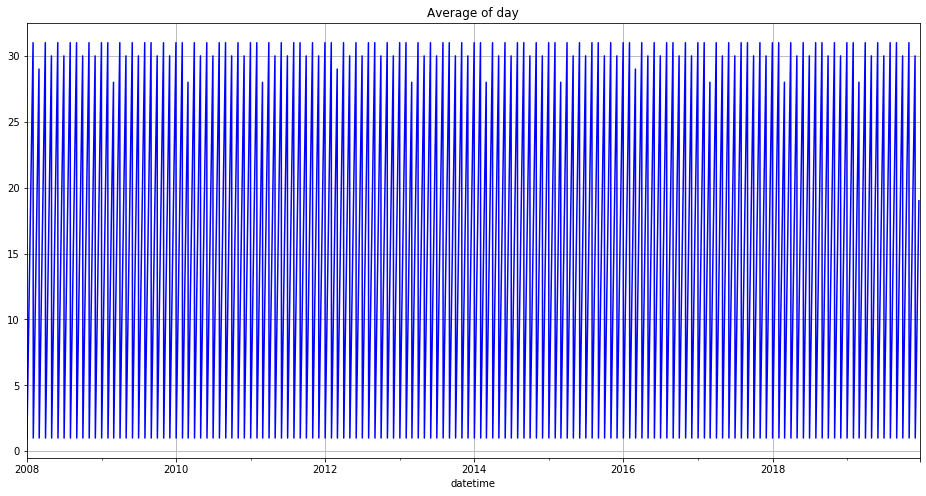

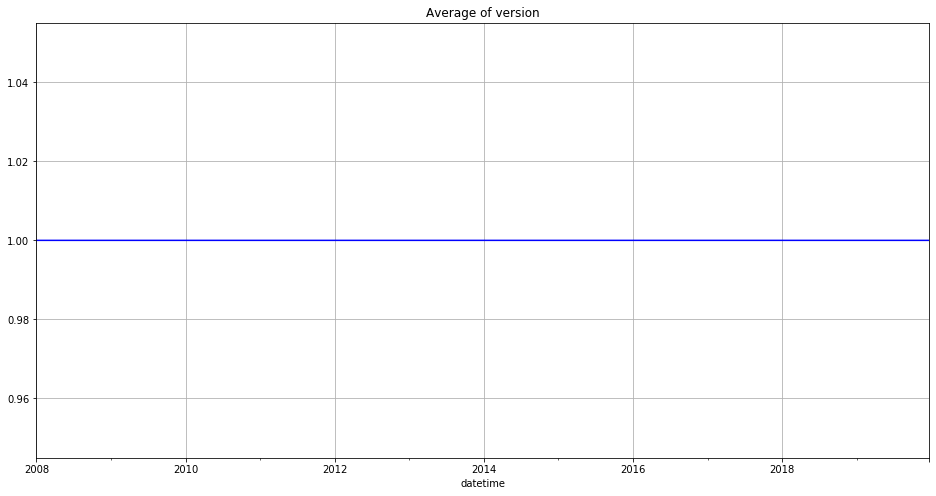

In [94]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2008, 1, 1), datetime.now()])
    plt.grid()
    
    # optionally, log images to the run
    #run.log_image(col, plot=plt)

## Drop uninteresting columns

In [103]:
df = df.drop(['version', 'year', 'day'], axis=1)
means = means.drop(['version', 'year', 'day'], axis=1)

## Zoom in on 2015

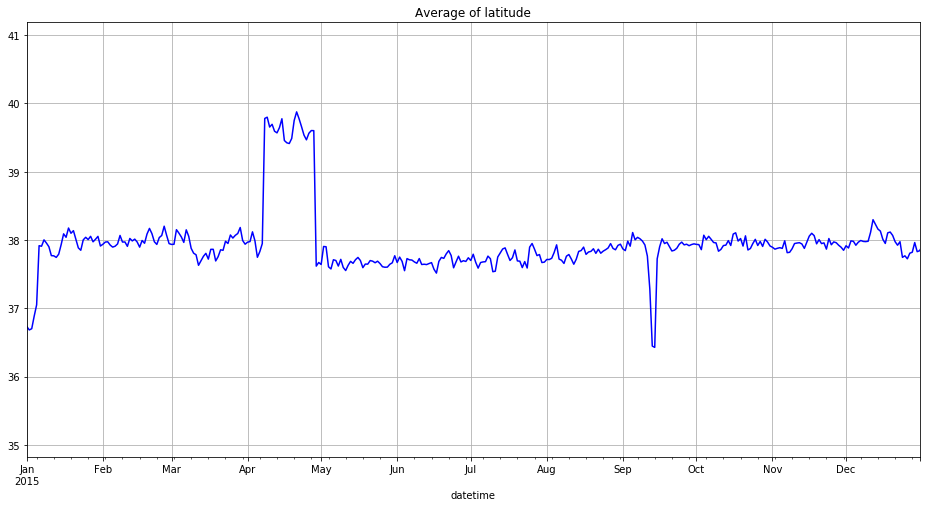

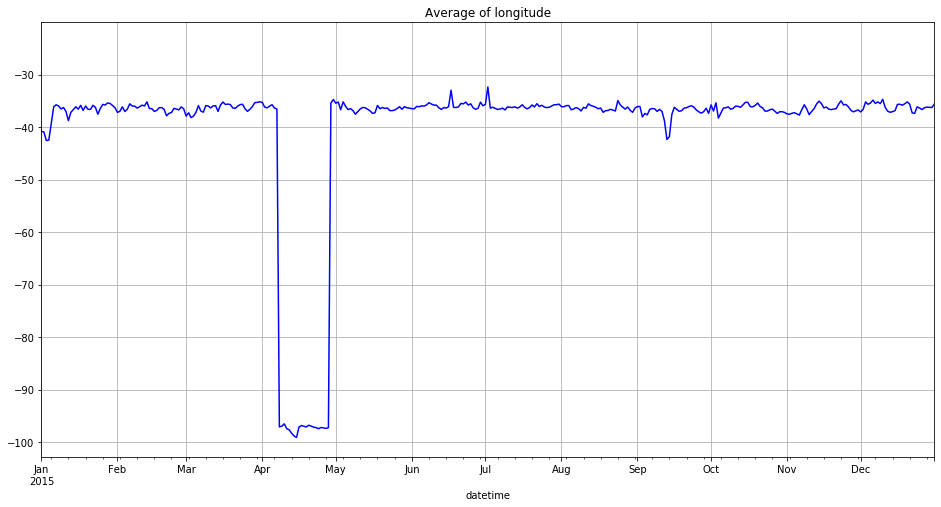

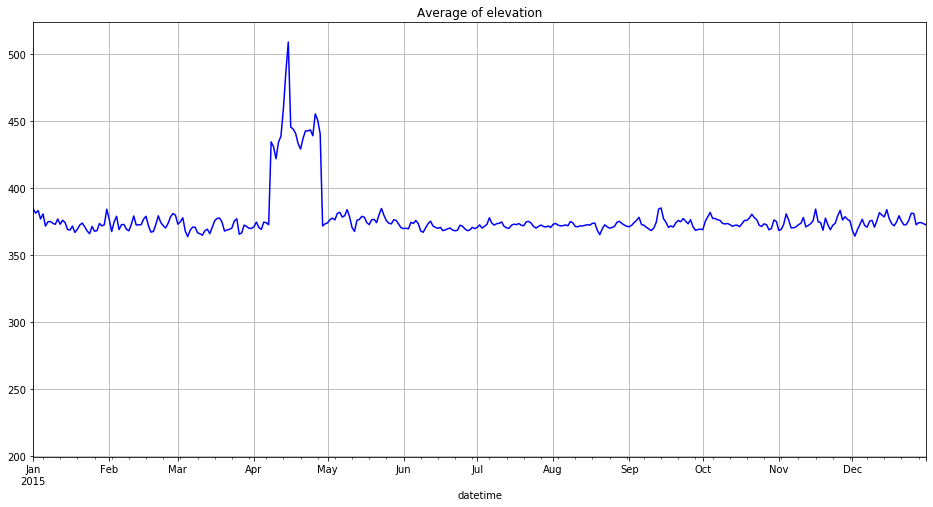

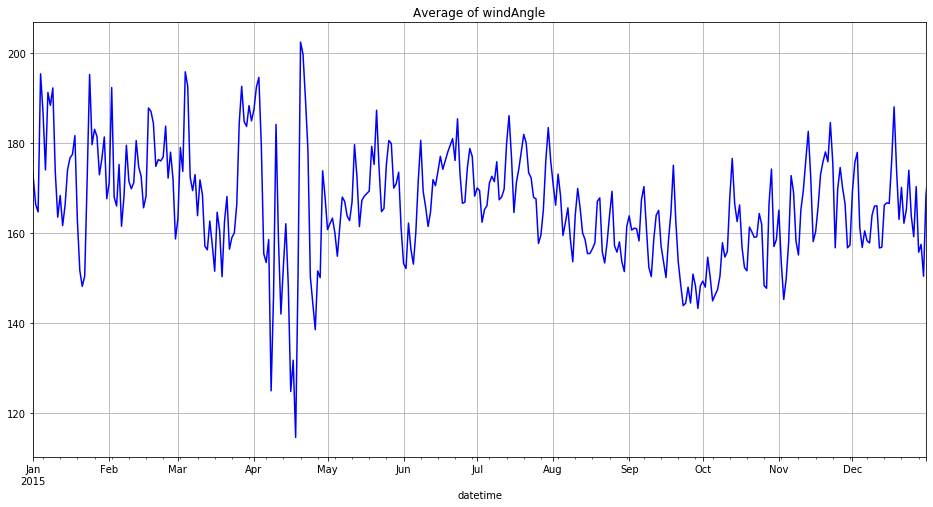

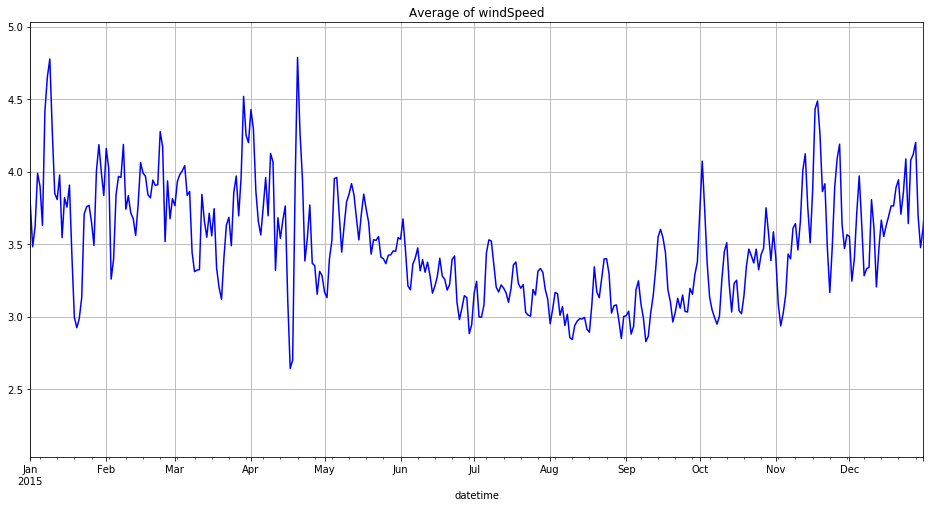

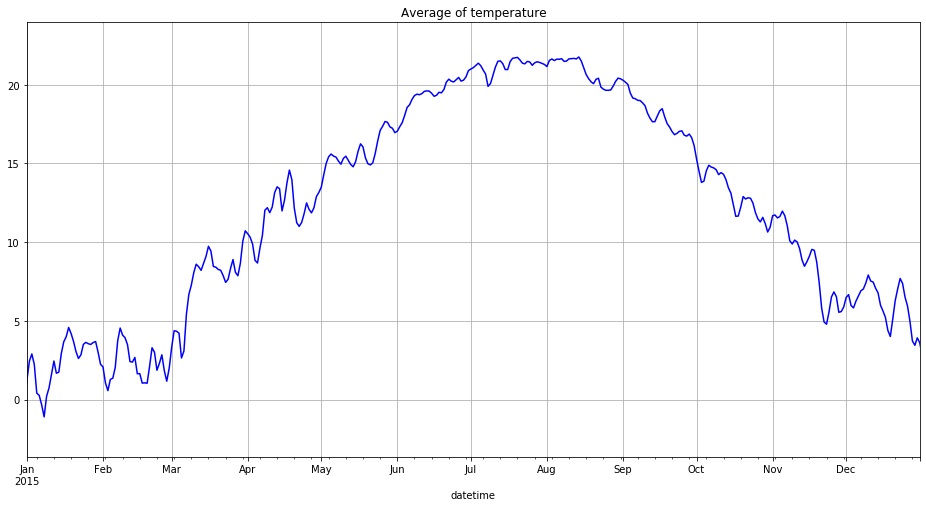

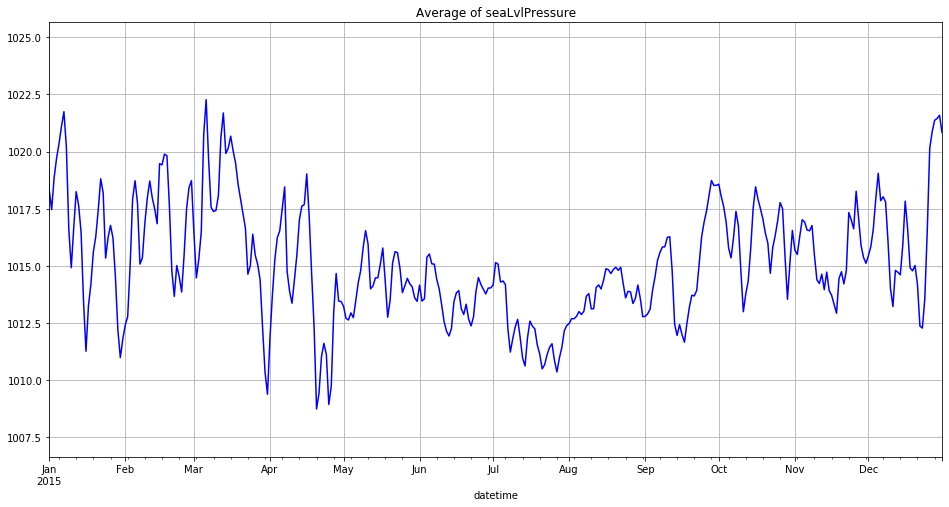

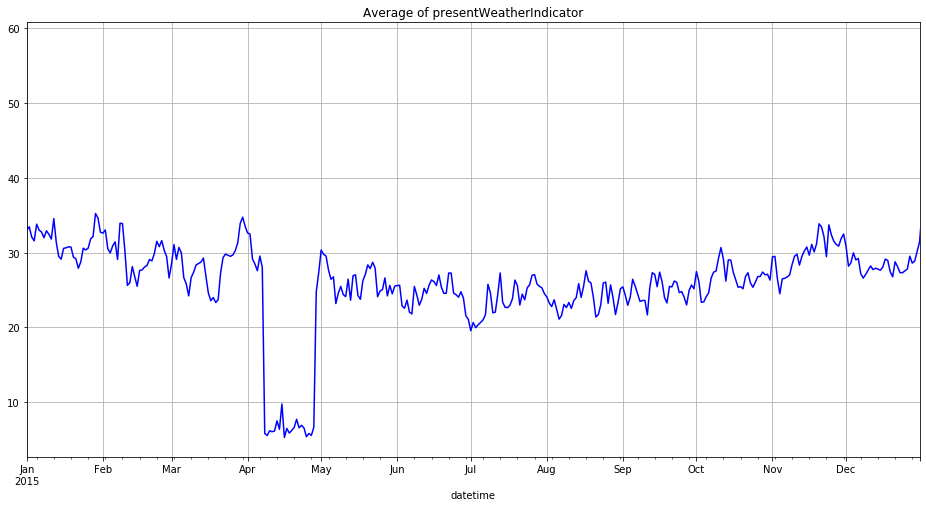

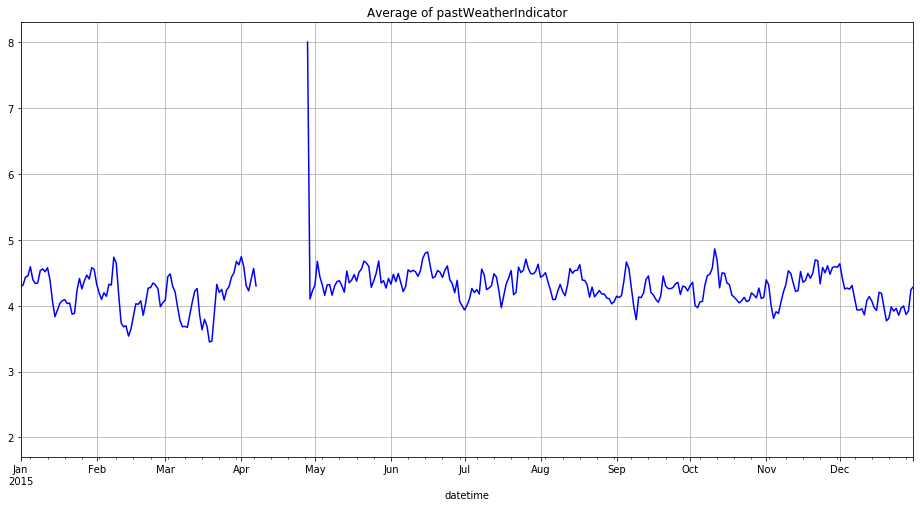

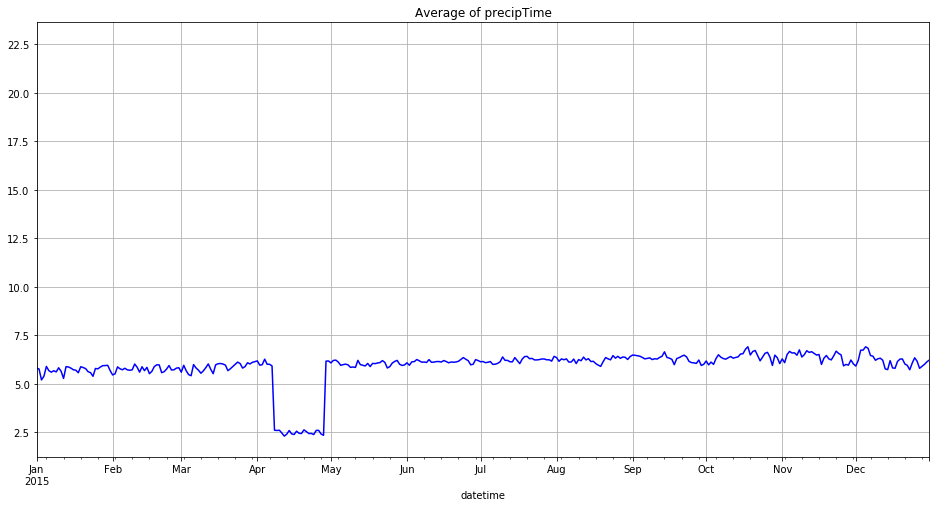

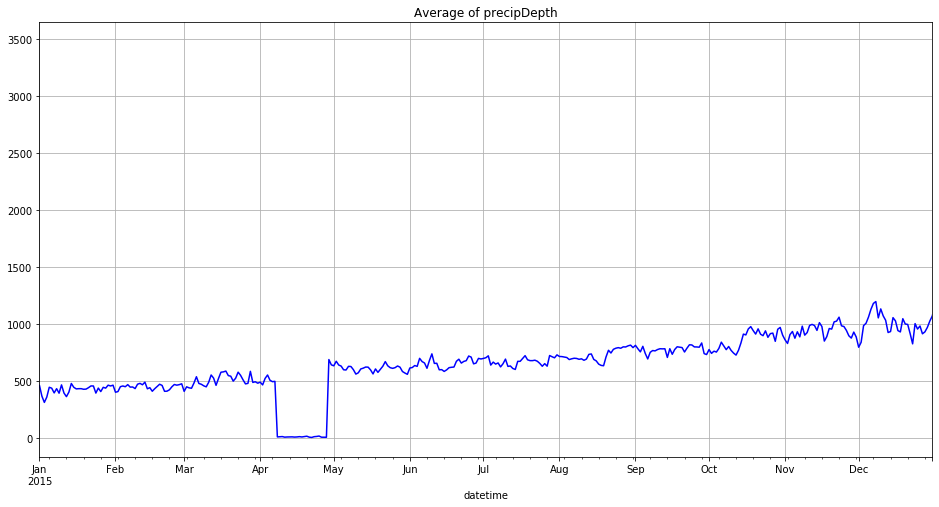

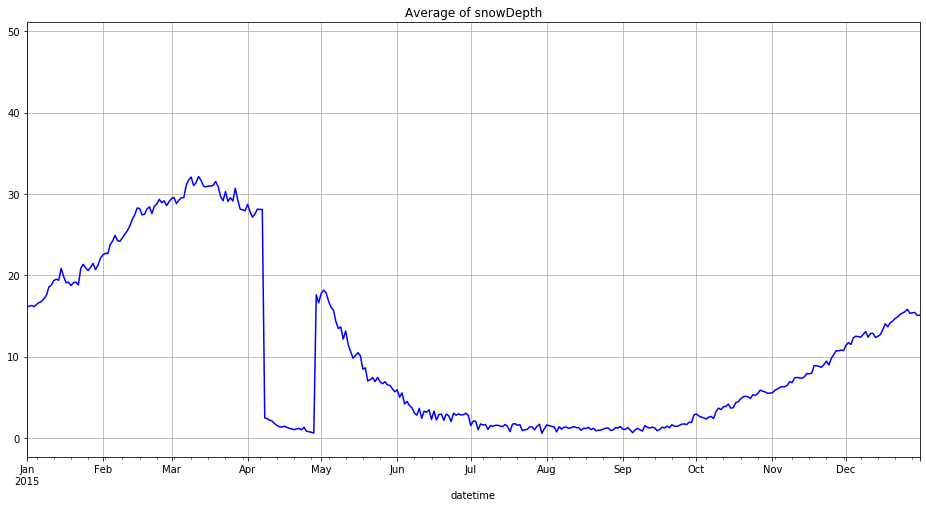

In [104]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2015, 1, 1), datetime(2015, 12, 31)])
    plt.grid()

In [128]:
df.index.head()[0] > datetime(2005, 1, 1)

True

In [132]:
df15 = df.loc[(df.index > datetime(2015, 1, 1))]

In [133]:
df15.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,cloudCoverage,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k
datetime,,,,,,,,,,,,,,,,,,,


In [ ]:
df = df.drop(['datetime'], axis=1)

In [ ]:
df.index

In [ ]:
def write_data(path):
    df.to_parquet(path)

In [ ]:
a = dask.delayed(write_data)(ds+'/dask/outputs/isd').compute()

In [ ]:
counts = df.groupby([df.index.month, df.index.year]).day.count().compute()

In [ ]:
cs = [counts[month][2015] for month in range(1, 13)]
cs

In [ ]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2015, 1, 1), datetime(2015, 12, 1)])
    plt.grid()
    
    run.log_image(col, plot=plt)

In [ ]:
df.memory_usage(index=True, deep=True).sum().compute()

In [ ]:
df.info()